In [ ]:
#| default_exp models.tide

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TiDE
> Time-series Dense Encoder (`TiDE`) is a MLP-based univariate time-series forecasting model. `TiDE` uses Multi-layer Perceptrons (MLPs) in an encoder-decoder model for long-term time-series forecasting. In addition, this model can handle exogenous inputs.

<br><br>**References**<br>-[Das, Abhimanyu, Weihao Kong, Andrew Leach, Shaan Mathur, Rajat Sen, and Rose Yu (2024). "Long-term Forecasting with TiDE: Time-series Dense Encoder."](http://arxiv.org/abs/2304.08424)<br>

![Figure 1. TiDE architecture.](imgs_models/tide.png)

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional

import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._modules import RevIN

## 1. Auxiliary Functions

## 1.1 MLP residual
An MLP block with a residual connection.

In [ ]:
#| export
class MLPResidual(nn.Module):
    """
    MLPResidual
    """   
    def __init__(self, input_dim, hidden_size, output_dim, dropout, layernorm):
        super().__init__()
        self.layernorm = layernorm
        if layernorm:
            self.norm = nn.LayerNorm(output_dim)

        self.drop = nn.Dropout(dropout)
        self.lin1 = nn.Linear(input_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)

    def forward(self, input):
        # MLP dense
        x = F.gelu(self.lin1(input))                                            
        x = self.drop(x)
        x = self.lin2(x)

        # Skip connection
        x_skip = self.skip(input)

        # Combine
        x = x + x_skip

        if self.layernorm:
            return self.norm(x)

        return x

## 2. Model

In [ ]:
#| export
class TiDE(BaseWindows):
    """ TiDE

    Time-series Dense Encoder (`TiDE`) is a MLP-based univariate time-series forecasting model. `TiDE` uses Multi-layer Perceptrons (MLPs) in an encoder-decoder model for long-term time-series forecasting.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `hidden_size`: int=1024, number of units for the dense MLPs.<br>
    `decoder_output_dim`: int=32, number of units for the output of the decoder.<br>
    `temporal_decoder_dim`: int=128, number of units for the hidden sizeof the temporal decoder.<br>
    `dropout`: float=0.0, dropout rate between (0, 1) .<br>
    `layernorm`: bool=True, if True uses Layer Normalization on the MLP residual block outputs.<br>
    `num_encoder_layers`: int=1, number of encoder layers.<br>
    `num_decoder_layers`: int=1, number of decoder layers.<br>
    `temporal_width`: int=4, lower temporal projected dimension.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>    
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References:**<br>
    - [Das, Abhimanyu, Weihao Kong, Andrew Leach, Shaan Mathur, Rajat Sen, and Rose Yu (2024). "Long-term Forecasting with TiDE: Time-series Dense Encoder."](http://arxiv.org/abs/2304.08424)

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False    

    def __init__(self,
                 h,
                 input_size,   
                 hidden_size = 128,
                 dropout = 0.2,
                 num_encoder_layers = 1,
                 n_heads = 4,
                 patch_len = 16,
                 stride = 8,
                 revin = False,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 dataloader_kwargs = None,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(TiDE, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            dataloader_kwargs=dataloader_kwargs,
            **trainer_kwargs
        )   
        self.h = h
        n_patches = int((input_size - patch_len) / stride + 1)
        self.revin = revin
        if self.revin:
          self.revin_layer = RevIN(1, affine=True)

        self.patch_len = min(input_size + stride, patch_len)
        self.stride = stride
        self.linear_projection = nn.Linear(n_patches, hidden_size)

        encoder_layer = nn.TransformerEncoderLayer(d_model = hidden_size, nhead = n_heads, dim_feedforward = 4 * hidden_size, dropout=dropout, activation=F.gelu, batch_first=True)
        encoder_norm = nn.LayerNorm(hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        output_network = [nn.Flatten(start_dim=-2),
                          nn.Linear(hidden_size * patch_len, h * self.loss.outputsize_multiplier),
                          nn.Dropout(dropout)]
        self.output_network = nn.Sequential(*output_network)

    def forward(self, windows_batch):
        # Parse windows_batch
        x             = windows_batch['insample_y'].unsqueeze(1)        #   [B, 1, L]

        # Revin
        if self.revin:
          x = x.permute(0, 2, 1)                                       #   [B, 1, L] -> [B, L, 1]
          x = self.revin_layer(x, mode="norm")
          x = x.permute(0, 2, 1)                                       #   [B, L, 1] -> [B, 1, L]

        # Unfold
        x = x.unfold(-1, self.patch_len, self.stride)               #   [B, 1, L] -> [B, 1, n_patches, patch_len]
        x = x.permute(0, 1, 3, 2)                                  #   [B, 1, n_patches, patch_len] -> [B, 1, patch_len, n_patches]
        
        # Linear projection
        x = self.linear_projection(x)                               #   [B, 1, patch_len, n_patches] -> [B, 1, patch_len, hidden_size]
        x = x.squeeze(1)                                            #   [B, 1, patch_len, hidden_size] -> [B, patch_len, hidden_size]

        # Transformer
        x = self.transformer_encoder(x)                                     #   [B, patch_len, hidden_size] -> [B, patch_len, hidden_size]                                        

        # Output network
        x = self.output_network(x)                                 #   [B, patch_len, hidden_size] -> [B, h * n_outputs]                                  
        x = x.reshape(-1, self.h, self.loss.outputsize_multiplier)  #   [B, h * n_outputs] -> [B, h, n_outputs]

        # Denorm
        if self.revin:
          x = self.revin_layer(x, mode="denorm")
          x = x.permute(0, 2, 1)                                        #   [B, n_outputs, h] -> [B, h, n_outputs] 

        # Map to output domain
        forecast = self.loss.domain_map(x)
        
        return forecast


In [ ]:
show_doc(TiDE)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/tide.py#L51){target="_blank" style="float:right; font-size:smaller"}

### TiDE

>      TiDE (h, input_size, hidden_size=128, dropout=0.2, num_encoder_layers=1,
>            n_heads=4, patch_len=16, stride=8, revin=False,
>            futr_exog_list=None, hist_exog_list=None, stat_exog_list=None,
>            exclude_insample_y=False, loss=MAE(), valid_loss=None,
>            max_steps:int=1000, learning_rate:float=0.001,
>            num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>            val_check_steps:int=100, batch_size:int=32,
>            valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>            inference_windows_batch_size=1024, start_padding_enabled=False,
>            step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>            drop_last_loader:bool=False, optimizer=None, optimizer_kwargs=None,
>            lr_scheduler=None, lr_scheduler_kwargs=None,
>            dataloader_kwargs=None, **trainer_kwargs)

*TiDE

Time-series Dense Encoder (`TiDE`) is a MLP-based univariate time-series forecasting model. `TiDE` uses Multi-layer Perceptrons (MLPs) in an encoder-decoder model for long-term time-series forecasting.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`hidden_size`: int=1024, number of units for the dense MLPs.<br>
`decoder_output_dim`: int=32, number of units for the output of the decoder.<br>
`temporal_decoder_dim`: int=128, number of units for the hidden sizeof the temporal decoder.<br>
`dropout`: float=0.0, dropout rate between (0, 1) .<br>
`layernorm`: bool=True, if True uses Layer Normalization on the MLP residual block outputs.<br>
`num_encoder_layers`: int=1, number of encoder layers.<br>
`num_decoder_layers`: int=1, number of decoder layers.<br>
`temporal_width`: int=4, lower temporal projected dimension.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>    
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References:**<br>
- [Das, Abhimanyu, Weihao Kong, Andrew Leach, Shaan Mathur, Rajat Sen, and Rose Yu (2024). "Long-term Forecasting with TiDE: Time-series Dense Encoder."](http://arxiv.org/abs/2304.08424)*

In [ ]:
show_doc(TiDE.fit, name='TiDE.fit')

---

### TiDE.fit

>      TiDE.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(TiDE.predict, name='TiDE.predict')

---

### TiDE.predict

>      TiDE.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                    **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

## 3. Usage Examples

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | linear_projection   | Linear             | 48     | train
4 | transformer_encoder | TransformerEncoder | 3.3 K  | train
5 | output_network      | Sequential         | 3.1 K  | train
-------------------------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 31.90it/s, v_num=9261, train_loss_step=0.691, train_loss_epoch=0.691, valid_loss=44.30] 


c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.71it/s]


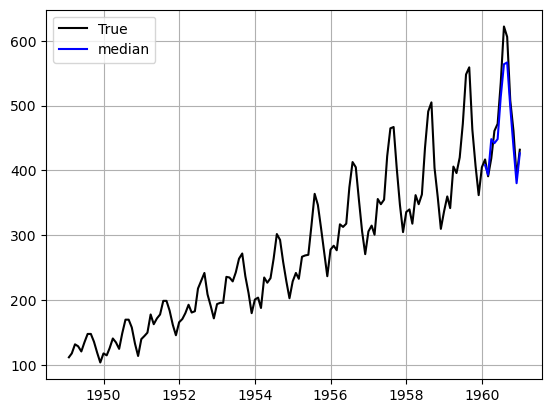

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
# from neuralforecast.models import TiDE
from neuralforecast.losses.pytorch import GMM, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[
            TiDE(h=12,
                input_size=24,
                loss=MAE(),
                max_steps=1000,
                scaler_type='robust',
                # layernorm=False,
                hidden_size=16,
                early_stop_patience_steps=3,
                # futr_exog_list=['y_[lag12]'],
                # hist_exog_list=None,
                # stat_exog_list=['airline1'],
                ),     
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TiDE'], c='blue', label='median')
# plt.fill_between(x=plot_df['ds'][-12:], 
#                  y1=plot_df['TiDE-lo-90'][-12:].values,
#                  y2=plot_df['TiDE-hi-90'][-12:].values,
#                  alpha=0.4, label='level 90')
plt.legend()
plt.grid()